In [ ]:
# If your container doesn't have any of the following resources, just run this cell once.
!pip install pymysql
!pip install sqlalchemy
!pip install gensim
import nltk
nltk.download('punkt')

In [2]:
# import packages
import pymysql
import pandas as pd
import getpass
from textblob import TextBlob
import re
import scipy
import matplotlib.pyplot as plt
import ipywidgets
from IPython.display import display, HTML
from ipywidgets import interact, interactive, fixed
from sqlalchemy import create_engine
from gensim.parsing.preprocessing import STOPWORDS
from collections import Counter
import sys
%matplotlib inline

## Set up our MySQL connection with SQL Alchemy (this helps us to read directly into Pandas DataFrames

In [3]:
engine = create_engine('mysql+pymysql://{0}:{1}@{2}:{3}/{4}'
                      .format('jovyan', 
                             getpass.getpass('Enter MySQL password for jovyan'),
                             'mysql',
                             '3306',
                             'mimic2'))

Enter MySQL password for jovyan········


## Before we move ahead, we will do some counts of patients, admissions and notes to ensure connectivity and also get a sense of the dataset

In [4]:
display(pd.read_sql_query('SELECT count(*) as PatientCount from d_patients', engine))
display(pd.read_sql_query('SELECT count(*) as AdmissionCount from admissions', engine))
display(pd.read_sql_query('SELECT count(*) as NoteCount from noteevents', engine))

,PatientCount
0,4000


,AdmissionCount
0,5074


,NoteCount
0,171927


## MIMIC-II (and MIMIC-III) has tables for Admissions, ICD-9 codes, notes and many other pieces of data

In [5]:
display(pd.read_sql_query('SELECT * from admissions LIMIT 5', engine))

,hadm_id,subject_id,admit_dt,disch_dt
0,28766,56,2644-01-17 00:00:00,2644-01-23 00:00:00
1,2075,3,2682-09-07 00:00:00,2682-09-18 00:00:00
2,20666,21,3138-10-29 00:00:00,3138-11-11 00:00:00
3,20882,21,3139-03-19 00:00:00,3139-03-28 00:00:00
4,12532,12,2875-09-26 00:00:00,2875-10-09 00:00:00


In [6]:
display(pd.read_sql_query('SELECT * from icd9 LIMIT 5', engine))

,subject_id,hadm_id,sequence,code,description
0,56,28766,1,198.3,SECONDARY MALIGNANT NEOPLASM OF BRAIN AND SPIN...
1,56,28766,2,162.8,MALIGNANT NEOPLASM OF OTHER PARTS OF BRONCHUS ...
2,56,28766,3,531.40,CHRONIC OR UNSPECIFIED GASTRIC ULCER WITH HEMO...
3,56,28766,4,276.1,HYPOSMOLALITY AND/OR HYPONATREMIA
4,56,28766,5,428.0,CONGESTIVE HEART FAILURE UNSPECIFIED


In [7]:
display(pd.read_sql_query('SELECT * from noteevents LIMIT 5', engine))

,subject_id,hadm_id,icustay_id,elemid,charttime,realtime,cgid,correction,cuid,category,title,text,exam_name,patient_info
0,56,28766,None,None,2644-01-17 00:00:00,None,None,None,None,DISCHARGE_SUMMARY,None,\n \n \n \nAdmission Date: [**2644-1-17**] ...,None,None
1,56,28766,None,None,2644-01-17 00:00:00,None,None,None,None,RADIOLOGY_REPORT,None,\n\n\n DATE: [**2644-1-17**] 10:53 AM\n ...,None,None
2,56,28766,None,None,2644-01-17 00:00:00,None,None,None,None,RADIOLOGY_REPORT,None,\n\n\n DATE: [**2644-1-17**] 10:53 AM\n ...,None,None
3,56,28766,None,None,2644-01-17 00:00:00,None,None,None,None,RADIOLOGY_REPORT,None,\n\n\n DATE: [**2644-1-17**] 10:43 AM\n ...,None,None
4,56,28766,None,None,2644-01-17 00:00:00,None,None,None,None,RADIOLOGY_REPORT,None,\n\n\n DATE: [**2644-1-17**] 6:37 AM\n ...,None,None


In [8]:
# now let's get a frame of Patient/Admit/Pneumonia
pneumonia_query = """
    SELECT 
a.subject_id
,a.hadm_id
,a.admit_dt
,(CASE WHEN pneu.HADM_ID IS NOT NULL THEN 1 ELSE 0 END) as Encounter_Pneumonia_Diagnosis
FROM admissions a
LEFT JOIN 
(
    SELECT
    d.HADM_ID
    FROM  icd9 d
    WHERE 
        (code like '486%%')
    GROUP BY d.HADM_ID
) pneu
ON a.HADM_ID = pneu.HADM_ID
"""
pat_admit_pneumonia_df = pd.read_sql_query(pneumonia_query, engine)
display(pat_admit_pneumonia_df)

,subject_id,hadm_id,admit_dt,Encounter_Pneumonia_Diagnosis
0,56,28766,2644-01-17 00:00:00,0
1,3,2075,2682-09-07 00:00:00,0
2,21,20666,3138-10-29 00:00:00,0
3,21,20882,3139-03-19 00:00:00,0
4,12,12532,2875-09-26 00:00:00,0
5,26,15067,3079-03-03 00:00:00,0
6,37,18052,3264-08-14 00:00:00,1
7,31,15325,2678-08-21 00:00:00,1
8,61,7149,3352-06-23 00:00:00,0
9,61,5712,3353-01-10 00:00:00,0


In [9]:
# let's get a count of how many PNEUMONIA vs NO-PNEUMONIA admits we have
pneumonia_admit_count_df = pat_admit_pneumonia_df.groupby('Encounter_Pneumonia_Diagnosis').size()
display(pneumonia_admit_count_df)

Encounter_Pneumonia_Diagnosis
0    4444
1     630
dtype: int64

In [10]:
# before pulling note text, let's get a distribution of how many RADIOLOGY reports
# typically exist per admission
visit_rad_report_count_query = """
SELECT
n.hadm_id
,count(*) as rad_note_count
FROM d_patients p
INNER JOIN noteevents n
    ON n.subject_id = p.subject_id
WHERE 
    Category = 'RADIOLOGY_REPORT' 
    AND (text like '%%CHEST (PORTABLE AP)%%' OR text like '%%CHEST (PA & LAT)%%')
    AND n.hadm_id IS NOT NULL
GROUP BY n.hadm_id
ORDER BY count(*) DESC
"""
visit_rad_report_count_df = pd.read_sql_query(visit_rad_report_count_query, engine)
display(visit_rad_report_count_df.head(10))

,hadm_id,rad_note_count
0,18885,93
1,10911,93
2,1908,84
3,15276,73
4,24742,69
5,3374,68
6,20737,60
7,25055,55
8,4419,54
9,2505,53


## Scipy had useful methods for describing distributions like our count of chest x-rays per encounter

In [11]:
rad_note_counts = visit_rad_report_count_df['rad_note_count'].values
scipy.stats.describe(rad_note_counts)

DescribeResult(nobs=3213, minmax=(1, 93), mean=6.552754435107376, variance=65.572947734511, skewness=3.5601972474671593, kurtosis=20.07247428711005)

## Notes in MIMIC have a category (e.g. "RADIOLOGY_REPORT") and within the text there are often "sub categories" on the second line of the file.  Pulling the appropriate sub categories as a few "like" statements does the job, but it is worth looking at some of these on your own

In [12]:
# before pulling note text, let's get a distribution of how many RADIOLOGY reports
# typically exist per admission
visit_rad_report_count_query = """
SELECT
n.hadm_id
,count(*) as rad_note_count
FROM d_patients p
INNER JOIN noteevents n
    ON n.subject_id = p.subject_id
WHERE 
    Category = 'RADIOLOGY_REPORT' 
    AND (text like '%%CHEST (PORTABLE AP)%%' OR text like '%%CHEST (PA & LAT)%%')
    AND n.hadm_id IS NOT NULL
GROUP BY n.hadm_id
ORDER BY count(*) DESC
"""
visit_rad_report_count_df = pd.read_sql_query(visit_rad_report_count_query, engine)
display(visit_rad_report_count_df)

,hadm_id,rad_note_count
0,18885,93
1,10911,93
2,1908,84
3,15276,73
4,24742,69
5,3374,68
6,20737,60
7,25055,55
8,4419,54
9,2505,53


## Some patients have only one radiology report but several have multiple.  This graph looks at that distribution

<BarContainer object of 59 artists>

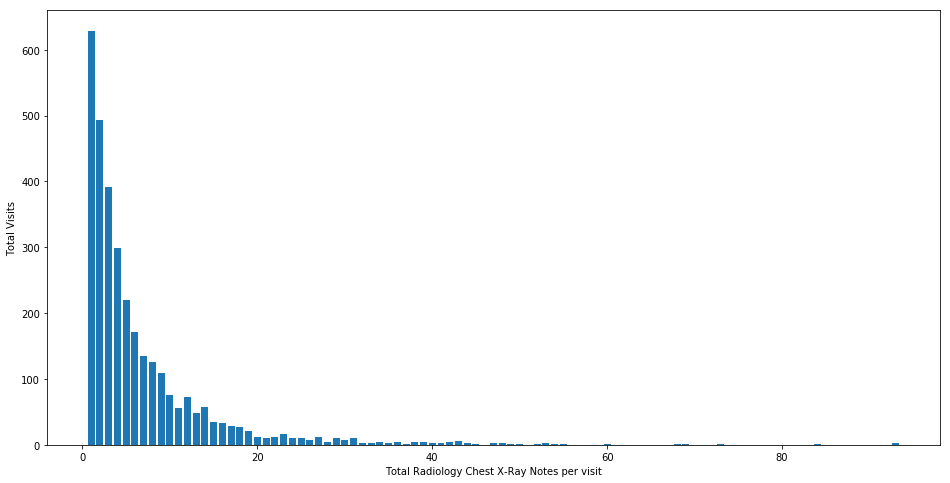

In [13]:
rad_note_count_grouping = visit_rad_report_count_df.groupby('rad_note_count').size()
#display(rad_note_count_grouping)

note_count_bins = rad_note_count_grouping.index.values
#print(note_count_bins)
note_frequencies = rad_note_count_grouping.values
#print(note_frequencies)

fig = plt.figure(figsize=(16, 8))

plt.xlabel('Total Radiology Chest X-Ray Notes per visit')
plt.ylabel('Total Visits')

plt.bar(note_count_bins, note_frequencies)

## We can then can pull these notes into a frame

In [14]:
# now let's pull a frame of all the FIRST (sorted by text which begins with date) CHEST X-RAY notes
chest_xray_note_query = """
SELECT
subject_id
,hadm_id
,LTRIM(RTRIM(text)) as text
FROM noteevents
WHERE category = 'RADIOLOGY_REPORT'
    AND (text like '%%CHEST (PORTABLE AP)%%' OR text like '%%CHEST (PA & LAT)%%')
    AND subject_id is not NULL
    AND hadm_id is not NULL
GROUP BY subject_id, hadm_id, text
"""
chest_xray_note_df = pd.read_sql_query(chest_xray_note_query, engine)
display(chest_xray_note_df.head(10))

/opt/conda/lib/python3.5/site-packages/pymysql/cursors.py:170: Warning: (1052, "Column 'text' in group statement is ambiguous")
  result = self._query(query)


,subject_id,hadm_id,text
0,3,2075,\n\n\n DATE: [**2682-9-10**] 5:22 AM\n ...
1,3,2075,\n\n\n DATE: [**2682-9-11**] 4:06 PM\n ...
2,3,2075,\n\n\n DATE: [**2682-9-11**] 8:05 AM\n ...
3,3,2075,\n\n\n DATE: [**2682-9-12**] 6:32 AM\n ...
4,3,2075,\n\n\n DATE: [**2682-9-13**] 6:01 AM\n ...
5,3,2075,\n\n\n DATE: [**2682-9-14**] 11:41 PM\n ...
6,3,2075,\n\n\n DATE: [**2682-9-7**] 10:23 PM\n ...
7,3,2075,\n\n\n DATE: [**2682-9-7**] 6:16 PM\n ...
8,3,2075,\n\n\n DATE: [**2682-9-8**] 1:00 AM\n ...
9,3,2075,\n\n\n DATE: [**2682-9-8**] 4:43 PM\n ...


## Much like a SQL "join" we can combine our frame which has ICD-9 codes with the frame that has notes so that we can sample from these intelligently

In [15]:
pneumonia_note_df = pd.merge(pat_admit_pneumonia_df, chest_xray_note_df, on = ['subject_id', 'hadm_id'])
display(pneumonia_note_df.head(20))

,subject_id,hadm_id,admit_dt,Encounter_Pneumonia_Diagnosis,text
0,56,28766,2644-01-17 00:00:00,0,\n\n\n DATE: [**2644-1-17**] 6:37 AM\n ...
1,56,28766,2644-01-17 00:00:00,0,\n\n\n DATE: [**2644-1-19**] 12:09 PM\n ...
2,3,2075,2682-09-07 00:00:00,0,\n\n\n DATE: [**2682-9-10**] 5:22 AM\n ...
3,3,2075,2682-09-07 00:00:00,0,\n\n\n DATE: [**2682-9-11**] 4:06 PM\n ...
4,3,2075,2682-09-07 00:00:00,0,\n\n\n DATE: [**2682-9-11**] 8:05 AM\n ...
5,3,2075,2682-09-07 00:00:00,0,\n\n\n DATE: [**2682-9-12**] 6:32 AM\n ...
6,3,2075,2682-09-07 00:00:00,0,\n\n\n DATE: [**2682-9-13**] 6:01 AM\n ...
7,3,2075,2682-09-07 00:00:00,0,\n\n\n DATE: [**2682-9-14**] 11:41 PM\n ...
8,3,2075,2682-09-07 00:00:00,0,\n\n\n DATE: [**2682-9-7**] 10:23 PM\n ...
9,3,2075,2682-09-07 00:00:00,0,\n\n\n DATE: [**2682-9-7**] 6:16 PM\n ...


## We sampled notes where the encounter was coded for Pneumonia (ICD-9 code 486.* ) and where it was not coded.  We performed stratified sampling of one percentage of notes from one and the remainder from the other.  We won't show that, but this is how we set up the group project

In [16]:
pneumonia_note_count_df = pneumonia_note_df.groupby('Encounter_Pneumonia_Diagnosis').size()
display(pneumonia_note_count_df)

Encounter_Pneumonia_Diagnosis
0    16103
1     3323
dtype: int64

In [17]:
# now let's list out some of the notes where Pneumonia WAS diagnosed
pneumonia_positive_notes = pneumonia_note_df[pneumonia_note_df['Encounter_Pneumonia_Diagnosis'] == 1]['text'].head(1).values
for note in pneumonia_positive_notes:
    print(note)
    #sys.stdout.write(note)




     DATE: [**3264-8-14**] 10:57 AM
     CHEST (PORTABLE AP)                                             Clip # [**Clip Number (Radiology) 10698**]
     Reason: 68 yo M with CHF and possible pna, now with acute worsening 
     ______________________________________________________________________________
     UNDERLYING MEDICAL CONDITION:
      68 year old man with sob, hx of chf, cad s/p CABG
     REASON FOR THIS EXAMINATION:
      68 yo M with CHF and possible pna, now with acute worsening of SOB and
      increasing O2 requirement, eval for worsening failure, new infiltrates or pulm
      process
     ______________________________________________________________________________
                                     FINAL REPORT
     PORTABLE CHEST:
     
     CLINICAL INDICATION:  Worsening shortness of breath and oxygen requirement.
     
     Comparison is made to prior chest radiographs of [**3264-1-29**] and [**8-14**], 2003.
     
     The heart is enlarged but stable in siz

In [18]:
# now let's list out some of the notes where Pneumonia WAS diagnosed
pneumonia_negative_notes = pneumonia_note_df[pneumonia_note_df['Encounter_Pneumonia_Diagnosis'] == 0]['text'].head(1).values
for note in pneumonia_negative_notes:
    #print(note)
    sys.stdout.write(note)




     DATE: [**2644-1-17**] 6:37 AM
     CHEST (PORTABLE AP)                                             Clip # [**Clip Number (Radiology) 12564**]
     Reason: NGT placement                                               
     Admitting Diagnosis: HEAD BLEED
     ______________________________________________________________________________
     UNDERLYING MEDICAL CONDITION:
      [**Age over 90 **] year old woman with SAH                                                      
     REASON FOR THIS EXAMINATION:
      NGT placement                                                                   
     ______________________________________________________________________________
                                     FINAL REPORT
     INDICATION:  A [**Age over 90 **]-year-old woman with SAH.  Nasogastric tube placement.
     
     TECHNIQUE:  Portable AP chest radiograph.
     
     There is no previous chest radiograph for comparison.
     
     FINDINGS:
     
     The patient is stat

## We can use a widgets to be able to drag back and forth between the set to display them easily

In [19]:
# This function let's us iterate through all documents and view the markup
def view_documents(reports):
    @interact(i=ipywidgets.IntSlider(min=0, max=len(reports)-1))
    def _view_document(i):
        report_html = reports[i].replace('\n', '<br>')
        
        display(HTML(report_html))
        
chest_xray_list = list(chest_xray_note_df['text'].values)
view_documents(chest_xray_list)

interactive(children=(IntSlider(value=0, description='i', max=19425), Output()), _dom_classes=('widget-interac…

## It be useful to use these chest x-ray radiology reports to get an idea of some of the language in these reports

## For example, let's look at what kinds of words and counts we see in this dataset

In [20]:
%%time 

MAX_REPORTS_FOR_WORD_COUNT = 50

# let's start by collecting words from all texts
chest_xray_words = []
STOPWORDS= frozenset([w.upper() for w in STOPWORDS])
sampled_xray_list = chest_xray_list[:MAX_REPORTS_FOR_WORD_COUNT]
for text in sampled_xray_list:
    words = TextBlob(text.lower()).words
    # extend() adds all elements from another list 
    chest_xray_words.extend(words)

CPU times: user 488 ms, sys: 68 ms, total: 556 ms
Wall time: 561 ms


In [21]:
chest_xray_word_set = set(chest_xray_words)
print('Total unique words in Chest X-ray reports : {0}'.format(len(chest_xray_word_set)))

Total unique words in Chest X-ray reports : 1049


In [22]:
# and then we can see the most common words in this set of documents
Counter(chest_xray_words).most_common(30)

[('the', 302),
 ('is', 180),
 ('of', 155),
 ('with', 136),
 ('and', 133),
 ('chest', 126),
 ('for', 101),
 ('reason', 100),
 ('clip', 96),
 ('in', 94),
 ('ap', 84),
 ('portable', 82),
 ('there', 78),
 ('right', 72),
 ('this', 68),
 ('no', 67),
 ('are', 65),
 ('left', 65),
 ('to', 62),
 ('pulmonary', 54),
 ('examination', 54),
 ('underlying', 53),
 ('placement', 53),
 ('man', 52),
 ('condition', 51),
 ('medical', 50),
 ('date', 50),
 ('report', 50),
 ('final', 50),
 ('number', 50)]

### Some ideas on selecting which reports to use 
![image.png](./Slide_pngs/Slide16.png)

## What sample size should you use?
![image.png](./Slide_pngs/Slide18.png)

<br/><br/>This material presented as part of the DeCART Data Science for the Health Science Summer Program at the University of Utah in 2018.<br/>
Presenters : Dr. Wendy Chapman, Jianlin Shi <br> Acknowledgement: Many thanks to Kelly Peterson and Olga Patterson because part of the materials are adopted from his previous work.